# Read, Parse, Process E-Commerce data on PySpark
eCommerce dataset: https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category

In [1]:
#conda install seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arrow-cpp-0.17.0           |py37hc4171bc_2_cpu        19.6 MB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py37hc8dfbb8_0         152 KB  conda-forge
    seaborn-0.10.1             |                1           4 KB  conda-forge
    seaborn-base-0.10.1        |             py_1         158 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        20.1 MB

The following NEW packages will be INSTAL

In [53]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualizations
import os
import matplotlib.pyplot as plt


## Data Download from Kaggle

In [2]:
#!pip install kaggle --upgrade

     |████████████████████████████████| 58 kB 5.3 MB/s eta 0:00:011
     |████████████████████████████████| 118 kB 32.6 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 14.3 MB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=e752a03686696410b13b86f751a5782cd8f3cb9ca6ec90f75f19358212950c1c
  Stored in directory: /home/jovyan/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
  Created wheel for python-slugify: filename=python_slugify-4.0.0-py2.py3-none-any.whl size=5486 sha256=92cf8ff9b03b29d2481f2b2209520fb077eaf536f0f3425de99f279e055f72e4
  Stored in directory: /home/jovyan/.cache/pip/wheels/7c/26/30/5f3d95da00fe94d0c4a5ec5b4ffd2e1ae18545f5fa61752e52
Successfully built kaggle python-slugify
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.9
    Uninstalling urllib3-1.25.9:
      Successfully uninstalled urllib3-1.25.9
Note: you may need to restart the kernel to use 

In [10]:
#!unzip data/ecommerce-behavior-data-from-multi-category-store.zip

Archive:  data/ecommerce-behavior-data-from-multi-category-store.zip
  inflating: 2019-Nov.csv            
  inflating: 2019-Oct.csv            


In [17]:
# NOTE: first to get kaggle api tiken from account page in Kaggle. Place it at ~/.kaggle/kaggle.json
# mkdir ~/.kaggle/
# nano ~/.kaggle/kaggle.json
# chmod 600 ~/.kaggle/kaggle.json
# kaggle datasets download mkechinov/ecommerce-behavior-data-from-multi-category-store
# unzip ecommerce-behavior-data-from-multi-category-store.zip

## Setup Spark

In [2]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors, Vector, DenseVector, SparseVector, VectorUDT
from pyspark.ml.stat import Summarizer
from pyspark.ml.feature import QuantileDiscretizer

In [3]:
from pyspark.sql import SparkSession

# Setup for 400GB Mem machine
config = pyspark.SparkConf().setAll([('spark.executor.memory', '350g'),
                                     ('spark.executor.instances', '1'),
                                     ('spark.cores.max', '64'),
                                     #('spark.cores.max', '3'),
                                     ('spark.executor.cores', '64'),
                                     ('spark.driver.memory','30g'),
                                     #('spark.local.dir', '/raid')
                                    ])
spark = SparkSession.builder.config(conf=config).appName("JobName").getOrCreate()

# Setup for 200GB Mem machine
# config = pyspark.SparkConf().setAll([('spark.executor.cores', '4'),
#                                      ('spark.executor.instances', '2'),
#                                      ('spark.executor.memory', '12g'), 
#                                      ('spark.executor.memoryOverhead', '2g'), 
#                                      #('spark.driver.cores', '4'),
#                                      #('spark.driver.memory', '12g'),
#                                      ('spark.dynamicAllocation.enabled', 'false'),
#                                      ('spark.io.compression.codec', 'snappy')
#                                     ])

# spark = SparkSession.builder.config(conf=config).appName("Recsys-Transformer-Research").getOrCreate()

## Read Data

#### Load 4 months dataset

In [8]:
!ls -la data

total 55251984
drwxr-sr-x 2 jovyan users       4096 Jun 17 04:09 .
drwsrwsr-x 1 jovyan users       4096 Jun 17 04:08 ..
-rw-r--r-- 1 jovyan users 9357988804 Jun 17 03:03 2019-Dec.csv
-rw-r--r-- 1 jovyan users 9006762395 Dec  9  2019 2019-Nov.csv
-rw-r--r-- 1 jovyan users 5668612855 Dec  9  2019 2019-Oct.csv
-rw-r--r-- 1 jovyan users 9267234550 Jun 17 03:10 2020-Apr.csv
-rw-r--r-- 1 jovyan users 7675550422 Jun 17 03:07 2020-Feb.csv
-rw-r--r-- 1 jovyan users 7777991113 Jun 17 03:04 2020-Jan.csv
-rw-r--r-- 1 jovyan users 7823838608 Jun 17 03:08 2020-Mar.csv


In [5]:
DATA_PATH = 'data/'
data_list = [os.path.join(DATA_PATH, f) for f in ['2019-Oct.csv', '2019-Nov.csv', '2019-Dec.csv',
                                                  '2020-Jan.csv', '2020-Feb.csv', '2020-Mar.csv', '2020-Apr.csv']]
#data_list = [os.path.join(DATA_PATH, '2019-Oct.csv')]

In [12]:
'''
data_csv_01 = "./2019-Oct.csv"
data_csv_02 = "./2019-Nov.csv"
# data_csv_03 = "/workspace/ecommerce-behavior-data-from-multi-category-store/2019-Dec.csv"
# data_csv_04 = "/workspace/ecommerce-behavior-data-from-multi-category-store/2020-Jan.csv"

# data_list = [data_csv_01, data_csv_02]
data_list = [data_csv_02]
'''

'\ndata_csv_01 = "./2019-Oct.csv"\ndata_csv_02 = "./2019-Nov.csv"\n# data_csv_03 = "/workspace/ecommerce-behavior-data-from-multi-category-store/2019-Dec.csv"\n# data_csv_04 = "/workspace/ecommerce-behavior-data-from-multi-category-store/2020-Jan.csv"\n\n# data_list = [data_csv_01, data_csv_02]\ndata_list = [data_csv_02]\n'

In [14]:
#! wc -l 2019-Oct.csv

42448765 2019-Oct.csv


In [122]:
#n_rows = 42448765
#perc_to_read = 0.000001
#rows_to_skip = int(n_rows * (1-perc_to_read))
#n_rows - rows_to_skip

43

#### Read through Spark from CSV

In [6]:
db_sb = spark.read.csv(data_list, inferSchema = True, header = True)
db_sb.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [7]:
db_sb = db_sb.withColumn('event_time_dt', F.to_timestamp('event_time','yyyy-MM-dd HH:mm:ss')) \
             .withColumn('ux_event_time', F.unix_timestamp('event_time_dt'))

In [8]:
@udf(returnType=StringType())
def get_main_category_udf(value):
    if value is None:
        return ''
    return value.split('.')[0]

In [9]:
@udf(returnType=StringType())
def empty_str_if_null(value):
    if value is None:
        return ''
    return value

In [10]:
db_sb = db_sb.withColumn('main_category', get_main_category_udf('category_code'))

In [ ]:
session_duration_minutes_pdf = pd.DataFrame(zip(percentiles+[0.95,0.99,0.999], 
                                          sessions_df.where(F.col('session_size') > 1).approxQuantile('session_duration_minutes', probabilities=percentiles+[0.95,0.99,0.999], relativeError=0.0001)),
                                         columns=['percentile', 'duration_minutes']).sort_values('percentile')
session_duration_minutes_pdf

In [112]:
percentiles = np.arange(0., 1.1, 0.1).tolist()

In [113]:
interactions_by_user_df = db_sb.groupBy('user_id').agg(F.count('*').alias('count'))

In [115]:
interactions_by_users_stats_pdf = pd.DataFrame(zip(percentiles+[0.99, 0.999], 
         interactions_by_user_df.approxQuantile('count', probabilities=percentiles+[0.99, 0.999], relativeError=0.0001)),
                                    columns=['percentile', 'interactions']).sort_values('percentile')
interactions_by_users_stats_pdf

,percentile,interactions
0,0.000,1.0
1,0.100,1.0
2,0.200,1.0
3,0.300,2.0
4,0.400,3.0
5,0.500,5.0
6,0.600,7.0
7,0.700,13.0
8,0.800,26.0
9,0.900,61.0


In [46]:
db_sb.groupBy('user_id').agg(F.count('*')).count()

15639803

In [49]:
db_sb.groupBy('user_session').agg(F.count('*')).count()

89693595

In [48]:
db_sb.groupBy('product_id').agg(F.count('*')).count()

386299

In [100]:
db_sb.groupBy('category_code').agg(F.count('*')).count()

142

In [102]:
db_sb.groupBy('brand').agg(F.count('*')).count()

6355

In [105]:
db_sb.agg(F.mean('price'), F.max('price')).show()

+------------------+----------+
|        avg(price)|max(price)|
+------------------+----------+
|285.46155945094375|   2574.07|
+------------------+----------+



In [107]:
db_sb.groupBy('event_type').count().show()

+----------+---------+
|event_type|    count|
+----------+---------+
|  purchase|  6848824|
|      view|385746849|
|      cart| 19114063|
+----------+---------+



In [108]:
db_sb.count()

411709736

In [111]:
19114063/411709736

0.046426065085815704

In [12]:
session_window = Window.partitionBy('user_session').orderBy('ux_event_time')

In [13]:
sessions_df = db_sb.select('user_id', 'user_session',
                          F.collect_list(empty_str_if_null('main_category')).over(session_window).alias('main_categories'),
                          F.collect_list(empty_str_if_null('category_code')).over(session_window).alias('category_codes'),
                          F.collect_list(empty_str_if_null('brand')).over(session_window).alias('brands'),
                          F.collect_list(empty_str_if_null('product_id')).over(session_window).alias('product_ids'),                           
                          F.collect_list('ux_event_time').over(session_window).alias('event_times'),
                          F.collect_list('event_type').over(session_window).alias('event_types'),   
                          F.first('ux_event_time').over(session_window).alias('session_start_time'),
                          F.last('ux_event_time').over(session_window).alias('session_end_time'), 
                          ) \
                    .withColumn('session_size', F.size('event_times')) \
                    .groupBy('user_id', 'user_session').agg(
                          F.max('session_size').alias('session_size'),
                          F.max('main_categories').alias('main_categories'),
                          F.max('category_codes').alias('category_codes'),
                          F.max('brands').alias('brands'),
                          F.max('product_ids').alias('product_ids'),
                          F.max('event_times').alias('event_times'),   
                          F.max('event_types').alias('event_types'),  
                          F.max('session_start_time').alias('session_start_time'),   
                          F.max('session_end_time').alias('session_end_time'), 
                    ) \
                    .withColumn('session_duration_minutes', (F.col('session_end_time') - F.col('session_start_time')) / (60))

In [101]:
db_sb.groupBy('main_category').agg(F.count('*')).count()

14

In [98]:
session_duration_minutes_pdf = pd.DataFrame(zip(percentiles+[0.95,0.99,0.999], 
                                          sessions_df.where(F.col('session_size') > 1).approxQuantile('session_duration_minutes', probabilities=percentiles+[0.95,0.99,0.999], relativeError=0.0001)),
                                         columns=['percentile', 'duration_minutes']).sort_values('percentile')
session_duration_minutes_pdf

,percentile,duration_minutes
0,0.000,0.000000
1,0.100,0.500000
2,0.200,0.933333
3,0.300,1.450000
4,0.400,2.116667
5,0.500,3.016667
6,0.600,4.283333
7,0.700,6.166667
8,0.800,9.450000
9,0.900,17.216667


In [21]:
MAX_VALID_DURATION_MIN_SESSION = 120 #2 hours

In [70]:
#sessions_df.where(F.col('session_start_time') > F.col('session_end_time')).count()

0

In [19]:
sessions_df.rdd.getNumPartitions()

200

In [20]:
sessions_df = sessions_df.repartition(1000)
sessions_df.rdd.getNumPartitions()

1000

In [13]:
sessions_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- session_size: integer (nullable = true)
 |-- main_categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- category_codes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- brands: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- product_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- event_times: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- event_types: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- session_start_time: long (nullable = true)
 |-- session_end_time: long (nullable = true)



## Analyzing intra-session similarities

In [15]:
sessions_df.show(10)

+---------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------------+
|  user_id|        user_session|session_size|     main_categories|      category_codes|              brands|         product_ids|         event_times|         event_types|session_start_time|session_end_time|
+---------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----------------+
| 49484535|c4154205-b7f0-420...|           2|[accessories, acc...|[accessories.umbr...|[parkmaster, park...|[18800010, 18800006]|[1587208531, 1587...|        [view, view]|        1587208531|      1587208565|
| 95388363|3570eab1-2a06-44b...|           1|         [furniture]|[furniture.living...|                  []|         [100036210]|        [1581865295]|              [vie

In [16]:
'''
@udf(returnType=ArrayType(StringType()))
def get_non_repeated_items(values):
    #Returns unique items, keep the order of their first occurence
    result = []
    for v in values:
        if v not in result:
            result.append(v)
    return result


@udf(returnType=ArrayType(StringType()))
def get_non_repeated_items(item_ids, additional_feature_values):
    #Returns unique items, keep the order of their first occurence
    ids = []
    result = []
    for i, v in zip(item_ids, additional_feature_values):
        if i not in result:
            ids.append(i)
            result.append(v)
    return result
'''

'\n@udf(returnType=ArrayType(StringType()))\ndef get_non_repeated_items(values):\n    #Returns unique items, keep the order of their first occurence\n    result = []\n    for v in values:\n        if v not in result:\n            result.append(v)\n    return result\n\n\n@udf(returnType=ArrayType(StringType()))\ndef get_non_repeated_items(item_ids, additional_feature_values):\n    #Returns unique items, keep the order of their first occurence\n    ids = []\n    result = []\n    for i, v in zip(item_ids, additional_feature_values):\n        if i not in result:\n            ids.append(i)\n            result.append(v)\n    return result\n'

In [38]:
def intra_session_avg_categ_similarity(values):
    if values is None:
        return None
    
    #Filtering out null or empty values
    values = list([v for v in values if v is not None and v != ''])
    
    if len(values) <= 1:
        return None
    
    matches = []
    for i in range(0, len(values)):
        for j in range(i+1, len(values)):
            if values[i] == values[j]:
                matches.append(1)
            else:
                matches.append(0)
                
    return sum(matches) / float(len(matches))

In [39]:
@udf(returnType=FloatType())
def intra_session_avg_categ_similarity_udf(values):
    return intra_session_avg_categ_similarity(values)

In [84]:
sessions_df.select('main_categories',
                   intra_session_avg_categ_similarity_udf('main_categories').alias('main_categories_intra_session_similarity')
                  ).show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+
|main_categories                                                                                                                                                                                       |main_categories_intra_session_similarity|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+
|[construction, construction, construction]                                                                                                                                                            |1.0                                     |
|[electronics, electronics, elec

In [105]:
sessions_df.select('product_ids', 'event_types',
                   intra_session_avg_categ_similarity_udf('product_ids').alias('product_ids_intra_session_similarity')
                  ).show(30, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+
|product_ids                                                                                                                                                                                                                                                                                                                                              |event_types                                                          

In [40]:
sessions_intra_sim_stats_df = sessions_df.select(
                   intra_session_avg_categ_similarity_udf('main_categories').alias('main_categories_sim'),
                   intra_session_avg_categ_similarity_udf('category_codes').alias('category_codes_sim'),
                   intra_session_avg_categ_similarity_udf('brands').alias('brands_sim'),
                   intra_session_avg_categ_similarity_udf('product_ids').alias('products_sim'),
                  ).cache()

In [41]:
session_size_stats_pdf = pd.DataFrame(zip(percentiles+[0.99, 0.999], 
         sessions_df.approxQuantile('session_size', probabilities=percentiles+[0.99, 0.999], relativeError=0.0001)),
                                    columns=['percentile', 'session_size']).sort_values('percentile')
session_size_stats_pdf

,percentile,session_size
0,0.000,1.0
1,0.100,1.0
2,0.200,1.0
3,0.300,1.0
4,0.400,1.0
5,0.500,2.0
6,0.600,3.0
7,0.700,4.0
8,0.800,6.0
9,0.900,11.0


In [50]:
main_categories_sim_stats_pdf = pd.DataFrame(zip(percentiles, 
         sessions_intra_sim_stats_df.approxQuantile('main_categories_sim', probabilities=percentiles, relativeError=0.0001)),
                                    columns=['percentile', 'session_size']).sort_values('percentile')
main_categories_sim_stats_pdf

,percentile,main_categories_sim
0,0.0,0.000000
1,0.1,0.358974
2,0.2,0.666667
3,0.3,1.000000
4,0.4,1.000000
5,0.5,1.000000
6,0.6,1.000000
7,0.7,1.000000
8,0.8,1.000000
9,0.9,1.000000


In [43]:
category_codes_sim_stats_pdf = pd.DataFrame(zip(percentiles, 
        sessions_intra_sim_stats_df.approxQuantile('category_codes_sim', probabilities=percentiles, relativeError=0.0001)),
                                    columns=['percentile', 'category_codes_sim']).sort_values('percentile')
category_codes_sim_stats_pdf

,percentile,category_codes_sim
0,0.0,0.000000
1,0.1,0.333333
2,0.2,0.500000
3,0.3,1.000000
4,0.4,1.000000
5,0.5,1.000000
6,0.6,1.000000
7,0.7,1.000000
8,0.8,1.000000
9,0.9,1.000000


In [44]:
brands_sim_stats_pdf = pd.DataFrame(zip(percentiles, 
        sessions_intra_sim_stats_df.approxQuantile('brands_sim', probabilities=percentiles, relativeError=0.0001)),
                                    columns=['percentile', 'brands_sim']).sort_values('percentile')
brands_sim_stats_pdf

,percentile,brands_sim
0,0.0,0.000000
1,0.1,0.048123
2,0.2,0.200000
3,0.3,0.333333
4,0.4,0.469697
5,0.5,0.800000
6,0.6,1.000000
7,0.7,1.000000
8,0.8,1.000000
9,0.9,1.000000


In [45]:
products_sim_stats_pdf = pd.DataFrame(zip(percentiles, 
        sessions_intra_sim_stats_df.approxQuantile('products_sim', probabilities=percentiles, relativeError=0.0001)),
                                    columns=['percentile', 'products_sim']).sort_values('percentile')
products_sim_stats_pdf

,percentile,products_sim
0,0.0,0.000000
1,0.1,0.000000
2,0.2,0.000000
3,0.3,0.035714
4,0.4,0.100000
5,0.5,0.166667
6,0.6,0.333333
7,0.7,0.475000
8,0.8,1.000000
9,0.9,1.000000


## Analyzing inter-sessions similarity

### Analyzing the similarity between two consecutive user sessions

In [14]:
user_window = Window.partitionBy('user_id').orderBy('session_start_time')

In [15]:
def remove_empty_values_from_list(values):
    return list([v for v in values if v is not None and v != ''])

def sessions_categ_set_sim(session1, session2):
    if session1 is None or session1 is None:
        return None
    
    #Filtering out null or empty values
    session1 = remove_empty_values_from_list(session1)
    session2 = remove_empty_values_from_list(session2)
    
    if len(session1) == 0 or len(session2) == 0:
        return None
    
    s1 = set(session1)
    s2 = set(session2)
    
    #Percentage of common values between 2 consecutive sessions compared to the number of values in the first session
    result = len(s1.intersection(s2)) / len(s1)
    return result

In [16]:
@udf(returnType=FloatType())
def sessions_categ_set_sim_udf(session1, session2):
    return sessions_categ_set_sim(session1, session2)

In [22]:
sessions_elapsed_time_df = sessions_df.where(F.col('session_duration_minutes') <= MAX_VALID_DURATION_MIN_SESSION) \
                                      .withColumn('session_start_time_prev', F.lag('session_start_time').over(user_window)) \
                                      .withColumn('session_end_time_prev', F.lag('session_end_time').over(user_window)) \
                                      .withColumn('elapsed_hours_since_last_session', (F.col('session_start_time') - F.col('session_end_time_prev')) / (60*60)) \
                                      .where((F.col('session_end_time_prev').isNotNull() & (F.col('elapsed_hours_since_last_session') >= 0)))

In [143]:
'''
sessions_temp_pdf = sessions_elapsed_time_df.where(F.col('elapsed_hours_since_last_session') < 0) \
            .select('elapsed_hours_since_last_session',
                    'session_start_time', 'session_end_time', 'session_start_time_prev', 'session_end_time_prev'
                   ).limit(100).toPandas()
sessions_temp_pdf
'''

"\nsessions_temp_pdf = sessions_elapsed_time_df.where(F.col('elapsed_hours_since_last_session') < 0)             .select('elapsed_hours_since_last_session',\n                    'session_start_time', 'session_end_time', 'session_start_time_prev', 'session_end_time_prev'\n                   ).limit(100).toPandas()\nsessions_temp_pdf\n"

In [23]:
sessions_elapsed_time_pdf = pd.DataFrame(zip(percentiles, 
        sessions_elapsed_time_df.approxQuantile('elapsed_hours_since_last_session', probabilities=percentiles, relativeError=0.0001)), 
        columns=['percentile', 'elapsed_hours'])
sessions_elapsed_time_pdf

,percentile,elapsed_hours
0,0.0,0.000000
1,0.1,0.021389
2,0.2,0.139722
3,0.3,1.690556
4,0.4,9.788333
5,0.5,23.783056
6,0.6,50.690556
7,0.7,107.378611
8,0.8,220.605278
9,0.9,529.296389


In [24]:
elapsed_hours_discretizer = QuantileDiscretizer(numBuckets=20, inputCol="elapsed_hours_since_last_session", outputCol="elapsed_hours_since_last_session_binned", 
                                                relativeError=0.001)
elapsed_hours_discretizer_fitted = elapsed_hours_discretizer.fit(sessions_elapsed_time_df)

In [25]:
elapsed_hours_buckets_thresholds = elapsed_hours_discretizer_fitted.getSplits()
list(elapsed_hours_buckets_thresholds)

[-inf,
 0.006944444444444444,
 0.022222222222222223,
 0.05388888888888889,
 0.1438888888888889,
 0.5063888888888889,
 1.758888888888889,
 4.354444444444445,
 10.045555555555556,
 17.351111111111113,
 23.934166666666666,
 37.050555555555555,
 51.759166666666665,
 74.82944444444445,
 109.11694444444444,
 154.345,
 223.47444444444446,
 335.8363888888889,
 549.0544444444445,
 986.5866666666667,
 inf]

In [26]:
sessions_elapsed_time_bucketized_df = elapsed_hours_discretizer_fitted.transform(sessions_elapsed_time_df)

In [27]:
elapsed_hours_bucket_labels = {}
for bin_id in range(len(elapsed_hours_buckets_thresholds)-1):        
    threshold = elapsed_hours_buckets_thresholds[bin_id]
    next_threshold = elapsed_hours_buckets_thresholds[bin_id+1]
    bucket_label = '[{:.2f} - {:.2f})'.format(threshold, next_threshold)
    elapsed_hours_bucket_labels[bin_id] = bucket_label
    
elapsed_hours_bucket_labels

{0: '[-inf - 0.01)',
 1: '[0.01 - 0.02)',
 2: '[0.02 - 0.05)',
 3: '[0.05 - 0.14)',
 4: '[0.14 - 0.51)',
 5: '[0.51 - 1.76)',
 6: '[1.76 - 4.35)',
 7: '[4.35 - 10.05)',
 8: '[10.05 - 17.35)',
 9: '[17.35 - 23.93)',
 10: '[23.93 - 37.05)',
 11: '[37.05 - 51.76)',
 12: '[51.76 - 74.83)',
 13: '[74.83 - 109.12)',
 14: '[109.12 - 154.34)',
 15: '[154.34 - 223.47)',
 16: '[223.47 - 335.84)',
 17: '[335.84 - 549.05)',
 18: '[549.05 - 986.59)',
 19: '[986.59 - inf)'}

In [28]:
elapsed_hours_bucket_label_udf = F.udf(lambda x: elapsed_hours_bucket_labels[int(x)], StringType())
sessions_elapsed_time_bucketized_labels_df = sessions_elapsed_time_bucketized_df.withColumn('elapsed_hours_since_last_session_range',
                                                                                           elapsed_hours_bucket_label_udf('elapsed_hours_since_last_session_binned'))

In [29]:
sessions_paired_previous_df = sessions_elapsed_time_bucketized_labels_df \
                                         .withColumn('main_categories_prev', F.lag('main_categories').over(user_window)) \
                                         .withColumn('category_codes_prev', F.lag('category_codes').over(user_window)) \
                                         .withColumn('brands_prev', F.lag('brands').over(user_window)) \
                                         .withColumn('product_ids_prev', F.lag('product_ids').over(user_window)) \
                                         .withColumn('main_categories_set_sim_prev', sessions_categ_set_sim_udf('main_categories_prev', 'main_categories')) \
                                         .withColumn('category_codes_set_sim_prev', sessions_categ_set_sim_udf('category_codes_prev', 'category_codes')) \
                                         .withColumn('brands_set_sim_prev', sessions_categ_set_sim_udf('brands_prev', 'brands')) \
                                         .withColumn('product_ids_set_sim_prev', sessions_categ_set_sim_udf('product_ids_prev', 'product_ids'))

In [30]:
sessions_paired_previous_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- session_size: integer (nullable = true)
 |-- main_categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- category_codes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- brands: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- product_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- event_times: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- event_types: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- session_start_time: long (nullable = true)
 |-- session_end_time: long (nullable = true)
 |-- session_duration_minutes: double (nullable = true)
 |-- session_start_time_prev: long (nullable = true)
 |-- session_end_time_prev: long (nullable = true)
 |-- elapsed_hours_since_last_session: double (nullable = true)
 |-- ela

In [31]:
sessions_paired_previous_sim_df = sessions_paired_previous_df.select('user_id', 'user_session', 'session_size', 
                                                                     'elapsed_hours_since_last_session', 'elapsed_hours_since_last_session_binned', 'elapsed_hours_since_last_session_range',
                                   sessions_categ_set_sim_udf('main_categories_prev', 'main_categories').alias('main_categories_set_sim_prev'),
                                   sessions_categ_set_sim_udf('category_codes_prev', 'category_codes').alias('category_codes_set_sim_prev'),
                                   sessions_categ_set_sim_udf('brands_prev', 'brands').alias('brands_set_sim_prev'),
                                   sessions_categ_set_sim_udf('product_ids_prev', 'product_ids').alias('product_ids_set_sim_prev')
                                  ).cache()

In [32]:
main_categories_set_sim_prev_stats_df = pd.DataFrame(zip(percentiles, 
        sessions_paired_previous_sim_df.approxQuantile('main_categories_set_sim_prev', probabilities=percentiles, relativeError=0.0001)),
            columns=['percentiles', 'main_categories_set_sim_prev'])
main_categories_set_sim_prev_stats_df

,percentiles,main_categories_set_sim_prev
0,0.0,0.0
1,0.1,0.0
2,0.2,0.0
3,0.3,0.0
4,0.4,0.5
5,0.5,1.0
6,0.6,1.0
7,0.7,1.0
8,0.8,1.0
9,0.9,1.0


In [88]:
category_codes_set_sim_prev_stats_df = pd.DataFrame(zip(percentiles, 
        sessions_paired_previous_sim_df.approxQuantile('category_codes_set_sim_prev', probabilities=percentiles, relativeError=0.0001)),
            columns=['percentiles', 'category_codes_set_sim_prev'])
category_codes_set_sim_prev_stats_df
category_codes_set_sim_prev_stats_df

,percentiles,category_codes_set_sim_prev
0,0.0,0.0
1,0.1,0.0
2,0.2,0.0
3,0.3,0.0
4,0.4,0.0
5,0.5,0.5
6,0.6,1.0
7,0.7,1.0
8,0.8,1.0
9,0.9,1.0


In [89]:
brands_set_sim_prev_stats_df = pd.DataFrame(zip(percentiles, 
        sessions_paired_previous_sim_df.approxQuantile('brands_set_sim_prev', probabilities=percentiles, relativeError=0.0001)),
            columns=['percentiles', 'main_categories_set_sim_prev'])
brands_set_sim_prev_stats_df

,percentiles,brands_set_sim_prev
0,0.0,0.0
1,0.1,0.0
2,0.2,0.0
3,0.3,0.0
4,0.4,0.0
5,0.5,0.0
6,0.6,0.5
7,0.7,1.0
8,0.8,1.0
9,0.9,1.0


In [90]:
product_ids_sim_prev_stats_df = pd.DataFrame(zip(percentiles, 
        sessions_paired_previous_sim_df.approxQuantile('product_ids_set_sim_prev', probabilities=percentiles, relativeError=0.0001)),
            columns=['percentiles', 'product_ids_set_sim_prev'])
product_ids_sim_prev_stats_df

,percentiles,product_ids_set_sim_prev
0,0.0,0.000000
1,0.1,0.000000
2,0.2,0.000000
3,0.3,0.000000
4,0.4,0.000000
5,0.5,0.000000
6,0.6,0.000000
7,0.7,0.000000
8,0.8,0.333333
9,0.9,1.000000


In [94]:
sessions_sim_merged_pdf = main_categories_set_sim_prev_stats_df.merge(category_codes_set_sim_prev_stats_df, on='percentiles') \
           .merge(brands_set_sim_prev_stats_df, on='percentiles') \
           .merge(product_ids_sim_prev_stats_df, on='percentiles')
sessions_sim_merged_pdf

,percentiles,main_categories_set_sim_prev,category_codes_set_sim_prev,brands_set_sim_prev,product_ids_set_sim_prev
0,0.0,0.0,0.0,0.0,0.000000
1,0.1,0.0,0.0,0.0,0.000000
2,0.2,0.0,0.0,0.0,0.000000
3,0.3,0.0,0.0,0.0,0.000000
4,0.4,0.5,0.0,0.0,0.000000
5,0.5,1.0,0.5,0.0,0.000000
6,0.6,1.0,1.0,0.5,0.000000
7,0.7,1.0,1.0,1.0,0.000000
8,0.8,1.0,1.0,1.0,0.333333
9,0.9,1.0,1.0,1.0,1.000000


In [96]:
sessions_sim_merged_pdf.columns = ['percentiles', 'main_category', 
                                          'category_code', 'brand', 'product_id']
sessions_sim_merged_pivoted_pdf = pd.melt(sessions_sim_merged_pdf, 
        id_vars="percentiles", var_name="categ_feature", value_name="intra_session_similarity")
sessions_sim_merged_pivoted_pdf

,percentiles,categ_feature,intra_session_similarity
0,0.0,main_category,0.000000
1,0.1,main_category,0.000000
2,0.2,main_category,0.000000
3,0.3,main_category,0.000000
4,0.4,main_category,0.500000
5,0.5,main_category,1.000000
6,0.6,main_category,1.000000
7,0.7,main_category,1.000000
8,0.8,main_category,1.000000
9,0.9,main_category,1.000000


[Text(0, 0, '0.0'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.30000000000000004'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.5'),
 Text(0, 0, '0.6000000000000001'),
 Text(0, 0, '0.7000000000000001'),
 Text(0, 0, '0.8'),
 Text(0, 0, '0.9'),
 Text(0, 0, '1.0')]

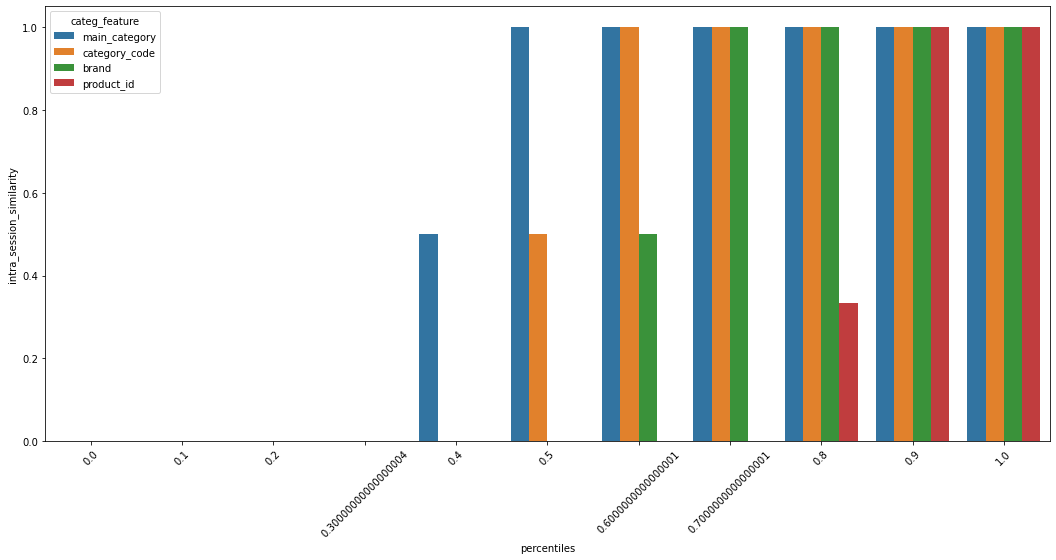

In [99]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x="percentiles", 
                 y="intra_session_similarity", hue="categ_feature", 
                 data=sessions_sim_merged_pivoted_pdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [139]:
sessions_paired_previous_sim_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- session_size: integer (nullable = true)
 |-- elapsed_hours_since_last_session: double (nullable = true)
 |-- elapsed_hours_since_last_session_range: string (nullable = true)
 |-- main_categories_set_sim_prev: float (nullable = true)
 |-- category_codes_set_sim_prev: float (nullable = true)
 |-- brands_set_sim_prev: float (nullable = true)
 |-- product_ids_set_sim_prev: float (nullable = true)



In [36]:
elapsed_time_stats_pdf = sessions_paired_previous_sim_df.groupBy('elapsed_hours_since_last_session_binned', 'elapsed_hours_since_last_session_range').agg(
    F.count('*').alias('count'),
    F.mean('main_categories_set_sim_prev').alias('main_categories_set_sim_prev_mean'),
    F.mean('category_codes_set_sim_prev').alias('category_codes_set_sim_prev_mean'),
    F.mean('brands_set_sim_prev').alias('brands_set_sim_prev_mean'),
    F.mean('product_ids_set_sim_prev').alias('product_ids_set_sim_prev_mean'),
).orderBy('elapsed_hours_since_last_session_binned').toPandas()
elapsed_time_stats_pdf

,elapsed_hours_since_last_session_binned,elapsed_hours_since_last_session_range,count,main_categories_set_sim_prev_mean,category_codes_set_sim_prev_mean,brands_set_sim_prev_mean,product_ids_set_sim_prev_mean
0,0.0,[-inf - 0.01),3764819,0.821005,0.786881,0.618001,0.151403
1,1.0,[0.01 - 0.02),3642861,0.753290,0.689713,0.536565,0.193082
2,2.0,[0.02 - 0.05),3679484,0.666134,0.580714,0.444824,0.191444
3,3.0,[0.05 - 0.14),3524107,0.685095,0.602905,0.463734,0.226254
4,4.0,[0.14 - 0.51),3716495,0.733468,0.662437,0.516588,0.274850
5,5.0,[0.51 - 1.76),3557925,0.719875,0.647734,0.511944,0.286070
6,6.0,[1.76 - 4.35),3565925,0.701959,0.626159,0.497847,0.280408
7,7.0,[4.35 - 10.05),3694608,0.671449,0.589140,0.466279,0.255017
8,8.0,[10.05 - 17.35),3619176,0.656698,0.575028,0.450951,0.242397
9,9.0,[17.35 - 23.93),3579217,0.628961,0.543083,0.424252,0.219469


In [84]:
elapsed_time_stats_selected_pdf = elapsed_time_stats_pdf[['elapsed_hours_since_last_session_range', 'main_categories_set_sim_prev_mean', 'category_codes_set_sim_prev_mean', 
                                'brands_set_sim_prev_mean', 'product_ids_set_sim_prev_mean']]
elapsed_time_stats_selected_pdf.columns = ['elapsed_hours_between_sessions','main_category', 'category_code', 'brand', 'product_id']
elapsed_time_stats_pivoted_pdf = pd.melt(elapsed_time_stats_selected_pdf, 
        id_vars="elapsed_hours_between_sessions", var_name="categ_feature", value_name="prev_session_sim")
elapsed_time_stats_pivoted_pdf

,elapsed_hours_between_sessions,categ_feature,prev_session_sim
0,[-inf - 0.01),main_category,0.821005
1,[0.01 - 0.02),main_category,0.753290
2,[0.02 - 0.05),main_category,0.666134
3,[0.05 - 0.14),main_category,0.685095
4,[0.14 - 0.51),main_category,0.733468
...,...,...,...
75,[154.34 - 223.47),product_id,0.111688
76,[223.47 - 335.84),product_id,0.096306
77,[335.84 - 549.05),product_id,0.068114
78,[549.05 - 986.59),product_id,0.047113


[Text(0, 0, '[-inf - 0.01)'),
 Text(0, 0, '[0.01 - 0.02)'),
 Text(0, 0, '[0.02 - 0.05)'),
 Text(0, 0, '[0.05 - 0.14)'),
 Text(0, 0, '[0.14 - 0.51)'),
 Text(0, 0, '[0.51 - 1.76)'),
 Text(0, 0, '[1.76 - 4.35)'),
 Text(0, 0, '[4.35 - 10.05)'),
 Text(0, 0, '[10.05 - 17.35)'),
 Text(0, 0, '[17.35 - 23.93)'),
 Text(0, 0, '[23.93 - 37.05)'),
 Text(0, 0, '[37.05 - 51.76)'),
 Text(0, 0, '[51.76 - 74.83)'),
 Text(0, 0, '[74.83 - 109.12)'),
 Text(0, 0, '[109.12 - 154.34)'),
 Text(0, 0, '[154.34 - 223.47)'),
 Text(0, 0, '[223.47 - 335.84)'),
 Text(0, 0, '[335.84 - 549.05)'),
 Text(0, 0, '[549.05 - 986.59)'),
 Text(0, 0, '[986.59 - inf)')]

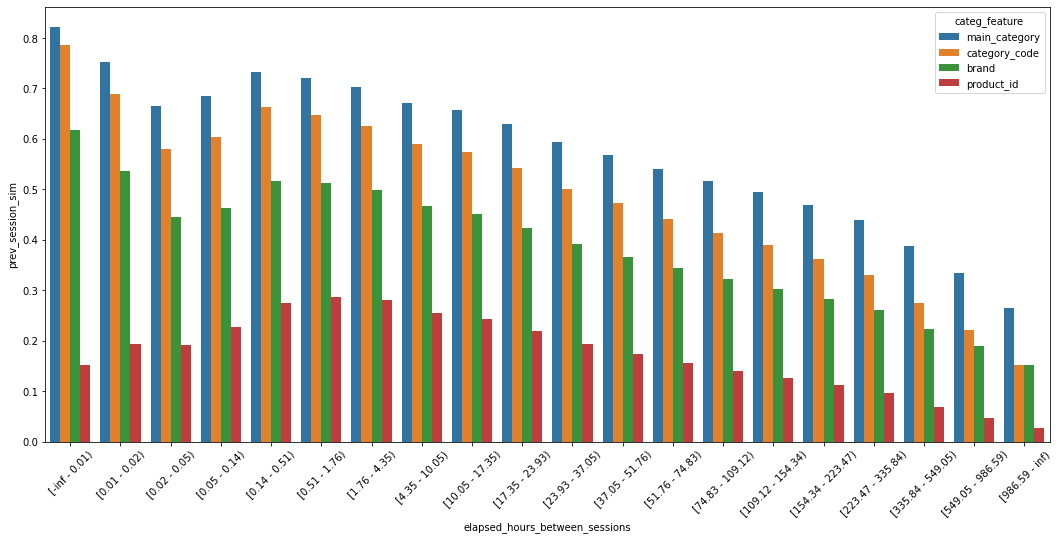

In [87]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x="elapsed_hours_between_sessions", 
                 y="prev_session_sim", hue="categ_feature", 
                 data=elapsed_time_stats_pivoted_pdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [37]:
session_size_stats_pdf = sessions_paired_previous_sim_df.where(F.col('session_size') <= 20).groupBy('session_size').agg(
    F.count('*').alias('count'),
    F.mean('main_categories_set_sim_prev').alias('main_categories_set_sim_prev_mean'),
    F.mean('category_codes_set_sim_prev').alias('category_codes_set_sim_prev_mean'),
    F.mean('brands_set_sim_prev').alias('brands_set_sim_prev_mean'),
    F.mean('product_ids_set_sim_prev').alias('product_ids_set_sim_prev_mean'),
).orderBy('session_size').toPandas()
session_size_stats_pdf

,session_size,count,main_categories_set_sim_prev_mean,category_codes_set_sim_prev_mean,brands_set_sim_prev_mean,product_ids_set_sim_prev_mean
0,1,28643676,0.605440,0.539913,0.419166,0.170831
1,2,10456661,0.561640,0.477750,0.366682,0.166626
2,3,7128363,0.582153,0.495431,0.386102,0.188072
3,4,5226149,0.589151,0.498854,0.390485,0.189116
4,5,3744863,0.587132,0.490365,0.382236,0.183884
5,6,2850262,0.587865,0.486051,0.378744,0.181239
6,7,2243845,0.592372,0.487020,0.381539,0.183728
7,8,1796022,0.595406,0.485851,0.382032,0.182596
8,9,1452021,0.598035,0.484535,0.382530,0.183201
9,10,1192572,0.599268,0.483072,0.383086,0.182409


### Analyzing sessions by user

In [18]:
users_sessions_df = sessions_df.withColumn('elapsed_secs_since_last_session', (F.col('session_start_time') - F.lag('session_end_time').over(user_window))) \
                                .select('user_id',
                                       F.collect_list('user_session').over(user_window).alias('sessions_ids'),
                                       F.collect_list('main_categories').over(user_window).alias('sessions_main_categories'),
                                       F.collect_list('category_codes').over(user_window).alias('sessions_category_codes'),
                                       F.collect_list('brands').over(user_window).alias('sessions_brands'),
                                       F.collect_list('product_ids').over(user_window).alias('sessions_product_ids'),
                                       F.collect_list('session_start_time').over(user_window).alias('sessions_start_times'),
                                       F.collect_list('session_end_time').over(user_window).alias('sessions_end_times'),
                                       F.collect_list('elapsed_secs_since_last_session').over(user_window).alias('elapsed_secs_since_last_sessions'),
                                    ) \
                                .groupBy('user_id').agg(
                                   F.max('sessions_ids').alias('sessions_ids'),
                                   F.max('sessions_main_categories').alias('sessions_main_categories'),
                                   F.max('sessions_category_codes').alias('sessions_category_codes'),
                                   F.max('sessions_brands').alias('sessions_brands'),
                                   F.max('sessions_product_ids').alias('sessions_product_ids'),
                                   F.max('sessions_start_times').alias('sessions_start_times'),
                                   F.max('sessions_end_times').alias('sessions_end_times'),
                                   F.max('elapsed_secs_since_last_sessions').alias('elapsed_secs_since_last_sessions'),
                                  ) \
                                .withColumn('sessions_count', F.size('sessions_ids'))

In [19]:
users_sessions_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- sessions_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sessions_main_categories: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- sessions_category_codes: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- sessions_brands: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- sessions_product_ids: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- sessions_start_times: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- sessions_end_times: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- elapsed_secs_since_last_sessions: array (nullable = true)
 | 

In [20]:
users_sessions_df.rdd.getNumPartitions()

200

In [22]:
sessions_categ_set_sim([0, 2], [0,2,3,4])

1.0

In [23]:
sessions_categ_set_sim([0, 1], [0,2,3,4])

0.5

In [24]:
sessions_categ_set_sim([1], [0,2,3,4])

0.0

In [28]:
def consecutive_sessions_categ_set_sim(sessions):
    if len(sessions) <= 1:
        return None
    
    results = []
    for i in range(0, len(sessions)-1):
        s1 = sessions[i]
        s2 = sessions[i+1]
        
        sim = sessions_categ_set_sim(s1, s2)
        results.append(sim)
        
    return sum(results) / float(len(results))

In [ ]:
consecutive_sessions_categ_set_sim(
    [
        [0,1],
        [0,3,4],
        [3]
    ]
)

In [29]:
@udf(returnType=FloatType())
def consecutive_sessions_categ_set_sim_udf(sessions):        
    return consecutive_sessions_categ_set_sim(sessions)

In [31]:
@udf(returnType=FloatType())
def array_min_udf(values):
    if values is None or len(values) == 0:
        return None
    return np.min(x)

@udf(returnType=FloatType())
def array_mean_udf(values):
    if values is None or len(values) == 0:
        return None
    return np.mean(x)

In [27]:
array_mean = udf(lambda x: float(np.mean(x)), FloatType())

In [33]:
consec_sessions_stats_df = users_sessions_df.select(
                         'user_id',
                         'sessions_ids',
                         'sessions_count',
                         'elapsed_secs_since_last_sessions',
                         array_min_udf('elapsed_secs_since_last_sessions').alias('min_elapsed_secs_between_sessions'),
                         array_mean_udf('elapsed_secs_since_last_sessions').alias('avg_elapsed_secs_between_sessions'),
                         consecutive_sessions_categ_set_sim_udf('sessions_main_categories').alias('main_categories_consec_sessions_avg_set_sim'),
                         consecutive_sessions_categ_set_sim_udf('sessions_category_codes').alias('category_codes_consec_sessions_avg_set_sim'),
                         consecutive_sessions_categ_set_sim_udf('sessions_brands').alias('brands_consec_sessions_avg_set_sim'),
                         consecutive_sessions_categ_set_sim_udf('sessions_product_ids').alias('product_ids_consec_sessions_avg_set_sim'),
                         ).cache()

In [34]:
dict(zip(percentiles, 
        consec_sessions_stats_df.approxQuantile('main_categories_consec_sessions_avg_set_sim', probabilities=percentiles, relativeError=0.0001)))

KeyboardInterrupt: 

In [ ]:
dict(zip(percentiles, 
        consec_sessions_stats_df.approxQuantile('category_codes_consec_sessions_avg_set_sim', probabilities=percentiles, relativeError=0.0001)))

In [ ]:
dict(zip(percentiles, 
        consec_sessions_stats_df.approxQuantile('brands_consec_sessions_avg_set_sim', probabilities=percentiles, relativeError=0.0001)))

In [ ]:
dict(zip(percentiles, 
        consec_sessions_stats_df.approxQuantile('product_ids_consec_sessions_avg_set_sim', probabilities=percentiles, relativeError=0.0001)))